# 线性回归

In [2]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error

## 数据准备

In [3]:
def shuffle_data(X,y,seed=None):
    # 将X和y的数据进行随机排序/乱序化
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx],y[idx] # 对于np.array, idx作为index数组可以改变array的顺序

In [4]:
def train_test_split(X,y,test_size=0.5,shuffle=True,seed=None):
    '将数据集根据test size分成训练集和测试集，可以指定是否随机洗牌'
    if shuffle:
        X,y=shuffle_data(X,y,seed)
    split_i = len(y)-int(len(y)//(1/test_size))
    # split_i = len(y)-int(len(y)*test_size)
    X_train,X_test=X[:split_i],X[split_i:]
    y_train,y_test=y[:split_i],y[split_i:]
    
    return X_train,X_test,y_train,y_test

In [5]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

In [6]:
X,y = make_regression(n_samples=100,n_features=1,noise=20)

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [8]:
X_train.shape

(80, 1)

因为使用make_regression函数使得X乱序，在绘制matplot的图像时会有问题，所以对X进行排序

In [9]:
s = sorted([(X_test[i][0],y_test[i]) for i in range(len(X_test))], key=lambda j:j[0])

In [10]:
s

[(-1.5506339344081885, -132.45810536795375),
 (-1.3657339780335982, -139.2770773624411),
 (-1.2560306365827523, -126.5672796571069),
 (-1.154578659959774, -136.17233838432037),
 (-1.1450841775025646, -130.92480748470294),
 (-1.0538590565218418, -99.76111359500328),
 (-0.7433485023896939, -76.37161541025361),
 (-0.5195543173196034, -34.53565438645779),
 (-0.4276349802161598, -51.3974051363619),
 (-0.14398437916043005, -41.25705927846178),
 (-0.10106681757472623, 15.063007898874963),
 (0.03718848084450358, 3.569103476418433),
 (0.08845923699948176, -14.30898768007279),
 (0.27030939071205345, -19.654371953699165),
 (0.2873023138273723, 26.36584422960201),
 (0.3717996104289664, 43.322869938082405),
 (0.5991069547313523, 56.94601554750421),
 (0.8713988612638535, 82.55760192410924),
 (0.8917215300190534, 68.29120695970843),
 (1.4010180478776382, 114.69960174716637)]

In [11]:
X_test=np.array([[j[0]] for j in s])
y_test=np.array([j[1] for j in s])

## 线性回归

In [12]:
class Regression(object):
    """
        基础线性回归模型，通过输入的X和y进行回归
        超参：
            n_iterations:int 训练的步数
            learning_rate:float 学习率
        内部函数：
            initialize_weights:初始化参数
            fit：开始训练
            predict：预测
        内部的数据：
            n_iterations
            learning_rate
            regularization:正则化参数
            regularization.grad:正则化的梯度函数
    """
    def __init__(self,n_iterations,learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.regularization = lambda x:0 # 无论给什么都是0，相当于默认为0
        self.regularization.grad = lambda x:0
    
    def initialize_weights(self,n_features):
        """
            初始化系数，输入的feature的个数，输出是一个随机初始化好的参数矩阵 A, b
            值域 [-1/sqrt(N), 1/sqrt(N)] 的正态分布
        """
        limit = 1/math.sqrt(n_features)
        self.w = np.random.uniform(-limit,limit,(n_features,))
        # Uniform Distribution/Xavier/MSRA
    
    def fit(self,X,y):
        # 插入偏置列 1 到X中
        X = np.insert(X,0,1,axis=1) # 给每一行的第0列增加一个1
        self.training_errors = [] # 保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1]) # 初始化参数w
        
        # 进行梯度下降迭代
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w) # 进行预测
            # 计算Loss
            mse = np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse) # 将Loss加入到training_errors的数组中
            # 计算带有正则化项的梯度
            grad_w = -(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            # 根据梯度下降算法更新参数
            self.w -= self.learning_rate*grad_w
    
    def predict(self,X):
        # 通过输入X预测一个样本
        X = np.insert(X,0,1,axis=1)
        pred = X.dot(self.w)
        return pred
    

In [13]:
model = Regression(n_iterations=1000,learning_rate=0.01)

In [14]:
model.fit(X_train,y_train)

Text(0.5, 0, 'Steps')

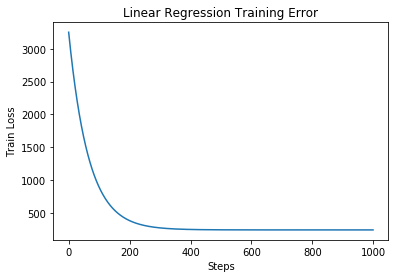

In [15]:
training = plt.plot(range(len(model.training_errors)),model.training_errors,label="Training Error")
plt.title("Linear Regression Training Error")
plt.ylabel('Train Loss')
plt.xlabel("Steps")

In [16]:
model.w

array([ 2.36684718, 88.95343163])

## 模型评测

In [17]:
y_pred = model.predict(X_test)

In [18]:
mse = mean_squared_error(y_pred,y_test)

In [19]:
mse

405.0256522950132

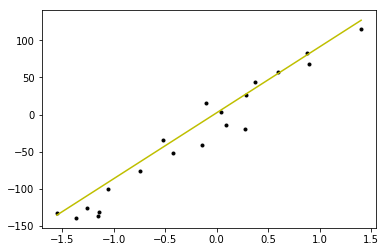

In [20]:
plt.plot(X_test,y_test,'k.')
plt.plot(X_test,y_pred,'Y')

## 带有最小二乘法的线性回归

In [21]:
def lsm_function(X,y):
    G = np.mat(np.insert(X, 0, 1, axis=1))
    return np.squeeze(np.asarray((G.T.dot(G)).I.dot(G.T).dot(y)))

In [22]:
lsm_function(X_train,y_train)

array([ 2.37434802, 88.99676614])

In [23]:
class LinearRegression(Regression):
    """
        带有最小二乘法的线性回归
        参数：
        ------------------
        n_iterations
        
        learning_rate
        
        gradient_descent:bool
            决定是否使用梯度下降法，如果True则使用梯度下降，False使用最小二乘
    """
    def __init__(self,n_iterations=500,learning_rate=0.1,gradient_descent=True):
        self.gradient_descent = gradient_descent
        self.regularization = lambda x:0 #正则化L2的loss
        self.regularization.grad = lambda x:0 #正则化的梯度，是上面的导数
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w = lsm_function(X,y)
        else:
            super(LinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LinearRegression,self).predict(X)

In [24]:
model = LinearRegression(n_iterations=1000,learning_rate=0.1,gradient_descent=False)

In [25]:
model.fit(X_train,y_train)

In [26]:
model.w

array([ 2.37434802, 88.99676614])

In [27]:
def test_and_draw(model):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    print("方差：",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')

方差： 404.7383545921972


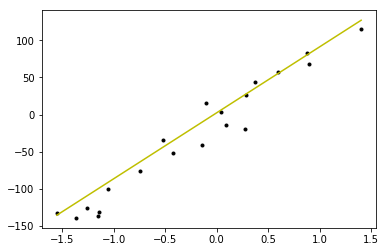

In [28]:
test_and_draw(model)

## 正则化回归

In [29]:
class l1_regularization():
    """
    L1正则化类/函数
    参数：
        alpha--L1正则化系数
    """
    def __init__(self,alpha):
        self.alpha = alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1) #np.linalg.norm求范数的
    def grad(self,w):
        # w>0 -> w'=1, w<0 -> w'=-1, w=0 -> w'=0 
        return self.alpha*np.sign(w)

In [30]:
l1 = l1_regularization(alpha=0.01)

In [31]:
l1([-3,4])

0.07

In [32]:
l1.grad([-3,4,0])

array([-0.01,  0.01,  0.  ])

## L2正则化参数

In [33]:
class l2_regularization():
    """
    L2正则化参数
    参数：
        alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha = alpha
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    def grad(self,w):
        return self.alpha*w

In [34]:
class LassoLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression,self).__init__(n_iterations,learning_rate)
    
    def fit(self,X,y):
        super(LassoLinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LassoLinearRegression,self).predict(X)

In [35]:
model = LassoLinearRegression(alpha=1.2,n_iterations=1000,learning_rate=0.1)

In [36]:
model.fit(X_train,y_train)

In [37]:
model.w

array([ 2.37434802, 88.99676614])

方差： 404.73835459219805


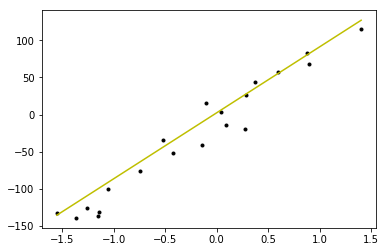

In [38]:
test_and_draw(model)

## Ridge线性回归

In [39]:
class RidgeLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l2_regularization(alpha=alpha)
        super(RidgeLinearRegression,self).__init__(n_iterations,learning_rate)
    
    def fit(self,X,y):
        super(RidgeLinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(RidgeLinearRegression,self).predict(X)

In [40]:
model = RidgeLinearRegression(alpha=1.2,n_iterations=1000,learning_rate=0.1)
model.fit(X_train,y_train)
model.w

array([ 2.37434802, 88.99676614])

## L1,L2调和的正则化

在调和的正则化中，

l1_ratio : 调和时，L1正则化的值所占的百分比[0,1]

_l2_ratio = 1 - l1_ratio(事实熵在算法中叶找不到 l2_ratio)

alpha: 全局的整体正则化权重

#### Loss = mse + alpha *  (l1_ratio * l1Loss + (1-l1_ratio) * l2Loss)

In [41]:
class l1_l2_regularization():
    """使用在ElasticNet中的正则化"""
    
    def __init__(self,alpha,l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
    
    def __call__(self,w):
        l1_loss = self.l1_ratio*np.linalg.norm(w,ord=1)
        l2_loss = (1-self.l1_ratio)*0.5*w.T.dot(w)#np.linalg.norm(w,ord=2)
        return self.alpha*(l1_loss+l2_loss)
    
    def grad(self,w):
        l1_grad = self.l1_ratio*np.sign(w)
        l2_grad = (1-self.l1_ratio)*w
        return self.alpha*(l1_grad+l2_grad)

In [42]:
l1_l2 = l1_l2_regularization(alpha=0.1)

In [44]:
l1_l2(np.array([3,4]))

0.9750000000000001

## ElasticNetLinearRegression

In [62]:
class ElasticLinearRegression(Regression):
    """
    ElasticNet线性回归算法
    ---------------------
    参数：
        alpha：全局正则化系数
        l1_ratio:l1正则化参数比例
        n_iterations
        learning_rate
    """
    def __init__(self,alpha=0.5,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01):
        self.regularization = l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        super(ElasticLinearRegression,self).__init__(n_iterations,learning_rate)
    
    def fit(self,X,y):
        super(ElasticLinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(ElasticLinearRegression,self).predict(X)

In [63]:
model=ElasticLinearRegression(l1_ratio=0.5,alpha=1.2)

In [64]:
model.fit(X_train,y_train)

方差： 404.7383546610098


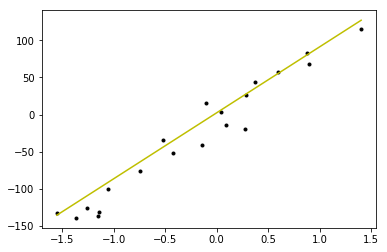

In [65]:
test_and_draw(model)

## 多项式回归

一阶多项式：x,y,z,x2,x3,x4...

二阶多项式：x1^2,x2^2,x3^2,x1x2,x1,x3,x2x3

三阶多项式： x1^3,x2^3,x1x1x2,x1x2x3...

### 构造多项式特征

In [57]:
from itertools import combinations_with_replacement

def polynomial_features(X,degree):
    n_samples,n_features=np.shape(X)
    # 对于每一行的feature构造排列组合，根据排列组合进行特征的乘积，形成新的X'

    def index_combinations():
        combs=[combinations_with_replacement(range(n_features),i) for i in range(0,degree+1)]
        new_combs=[item for sub in combs for item in sub]
        return new_combs
    print("Feature 列的排列组合：->", [x for x in index_combinations()])
    comb = index_combinations()
    feature_length=len(comb)
    output=np.empty((n_samples,feature_length))
    for i,index_combs in enumerate(comb):
        output[:,i] = np.prod(X[:, index_combs],axis=1)
    return output

In [58]:
polynomial_features(np.array([[1,2,3],[4,5,6]]),degree=2)

Feature 列的排列组合：-> [(), (0,), (1,), (2,), (0, 0), (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)]


array([[ 1.,  1.,  2.,  3.,  1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5.,  6., 16., 20., 24., 25., 30., 36.]])

In [60]:
for x in combinations_with_replacement([0,1],0):print(x)

()


In [73]:
class PolyRegression(Regression):
    """
    多项式回归就是将原来的feature转换成多阶的新feature，之后进行线性回归：
    ------------------
    参数：
        degree：最大的阶数
        
        n_iterations:float
        
        learning_rate:float
    """
    def __init__(self,degree,n_iterations=3000,learning_rate=0.01):
        self.degree = degree
        
        self.regularization = lambda x:0
        
        self.regularization.grad = lambda x:0
        
        super(PolyRegression,self).__init__(n_iterations=n_iterations,learning_rate = learning_rate)
        
    def fit(self,X,y):
        
        X = polynomial_features(X,degree=self.degree)
        
        super(PolyRegression,self).fit(X,y)
    
    def predict(self,X):
        
        X =polynomial_features(X,degree=self.degree)
        
        return super(PolyRegression,self).predict(X)

In [83]:
model = PolyRegression(degree=4)

In [84]:
model.fit(X_train,y_train)

Feature 列的排列组合：-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0)]


Feature 列的排列组合：-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0)]
方差： 409.4688499542538


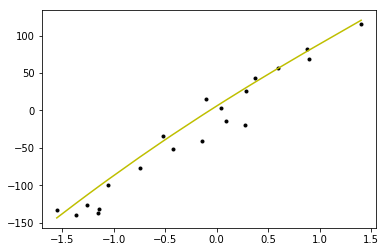

In [85]:
test_and_draw(model)

## 数据的Normalize变换（归一化操作）

行归一化

In [88]:
def normalize(X,axis=1,order=2):
    "将数据集的每一行进行列的归一化--每一行的向量的L2范数归一"
    L2 = np.linalg.norm(X,order,axis)
    L2[L2==0]=1 #为了避免滤掉为0的L2距离，在归一化的时候会出现除零问题
    return X/np.expand_dims(L2,axis)

In [89]:
normalize([[1,2],[3,4]],order=2,axis=1)

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [90]:
class LassoRegression(Regression):
    """带有L1范数的Lasso多项式回归
    ----------------------
    degree:多项式的最高阶
    
    alpha：L1的系数
    
    n_iteration:float
    
    learning_rate:int
    
    normalized:bool
    """
    
    def __init__(self,degree,alpha,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree = degree
        self.regularization = l1_regularization(alpha=alpha)
        self.normalized=normalized
        super(LassoRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X =  polynomial_features(X,degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(LassoRegression,self).fit(X,y)
    
    def predict(self,X):
        X=polynomial_features(X,degree=self.degree)
        if self.normalized:
            X = normalize(X)
        return super(LassoRegression,self).predict(X)

In [94]:
model = LassoRegression(degree=5,alpha=200,n_iterations=2000,learning_rate=0.1)

In [95]:
model.fit(X_train,y_train)

Feature 列的排列组合：-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0, 0)]


In [96]:
model.w

array([ -1.01965748,   8.75143428,  77.20617466,  -2.00690342,
       -33.28133564,   0.94242686, 193.80633867])

Feature 列的排列组合：-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0, 0)]
方差： 396.33265341848244


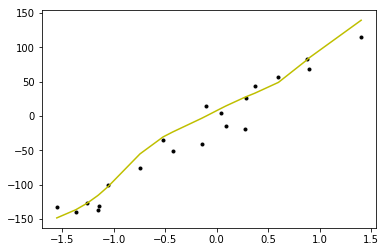

In [97]:
test_and_draw(model)

## 带有多项式的Ridge回归

In [108]:
class RidgeRegression(Regression):
    """带有多项式和归一化的Ridge回归
    ------------------------------
    参数：
        
        degree：最大阶数
        
        alpha：正则化系数
        
        n_iterations：步数
        
        learning_rate：步长
        
        normalized
    """
    def __init__(self,degree,alpha,n_iterations=3000,learning_rate=0.01, normalized=True):
        self.degree=degree
        self.regularization = l2_regularization(alpha=alpha)
        self.normalized = normalized
        super(RidgeRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X = polynomial_features(X, degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(RidgeRegression,self).fit(X,y)
    
    def predict(self,X):
        X = polynomial_features(X, degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return(super(RidgeRegression,self).predict(X))

In [109]:
model = RidgeRegression(degree=3,alpha=100,n_iterations=1000,learning_rate=1)

In [110]:
model.fit(X_train,y_train)

Feature 列的排列组合：-> [(), (0,), (0, 0), (0, 0, 0)]


Feature 列的排列组合：-> [(), (0,), (0, 0), (0, 0, 0)]
方差： 402.1395384367315


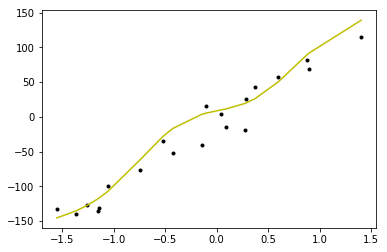

In [111]:
test_and_draw(model)

In [112]:
class ElasticNetRegression(Regression):
    """
    带有L1L2调和的线性回归
    --------------------
    
    degree
    
    alpha
    
    l1_ratio
    
    n_iterations
    
    learning_rate
    
    normalized
    """
    def __init__(self,degree,alpha=0.5,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01,normalized=True):
        self.degree= degree
        self.regularization = l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        self.normalized = normalized
        super(ElasticNetRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        X = polynomial_features(X, degree=self.degree)
        if self.normalized:
            X=normalize(X)
        super(ElasticNetRegression,self).fit(X,y)
    
    def predict(self,X):
        X = polynomial_features(X, degree=self.degree)
        if self.normalized:
            X=normalize(X)
        return(super(ElasticNetRegression,self).predict(X))  

In [113]:
model = ElasticNetRegression(degree=4,alpha=20,n_iterations=500,learning_rate=0.1)

In [114]:
model.fit(X_train,y_train)

Feature 列的排列组合：-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0)]


Feature 列的排列组合：-> [(), (0,), (0, 0), (0, 0, 0), (0, 0, 0, 0)]
方差： 436.7100563671055


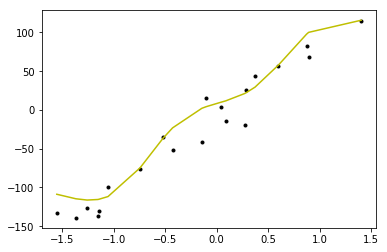

In [115]:
test_and_draw(model)

## 读入真实的数据

In [116]:
import pandas as pd

In [ ]:
train = pd.read_csv()

In [ ]:
y = np.asarray(train['SalePrice'])